In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL

from utils import  (evaluate_model, poly_kernel, gauss_kernel, scoring,
                    DATA_CMAP, DATA_COLORS, DATA_MARKERS, plot_e_a_mu)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
N = 1000
D = 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
corner = 2
centers = [[-corner, -corner], [-corner, corner],
           [corner, -corner], [corner, corner]]

X, y = make_blobs(n_samples=N, centers=centers, cluster_std=1.2)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[(y==0) | (y==3)] = -1
y[y==2] = 1
data['y'] = y

display(data.head())
data.describe()

,x1,x2,y
0,-2.680523,2.215322,1
1,2.353316,-2.214380,1
2,-2.427676,-1.675367,-1
3,2.127091,-0.126434,1
4,1.680862,2.755998,-1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,0.018888,0.035344,0.0000
std,2.279776,2.321586,1.0005
min,-5.489046,-5.092947,-1.0000
25%,-1.963051,-1.923341,-1.0000
50%,0.130044,-0.110316,0.0000
75%,1.950927,2.058677,1.0000
max,5.315621,6.057714,1.0000


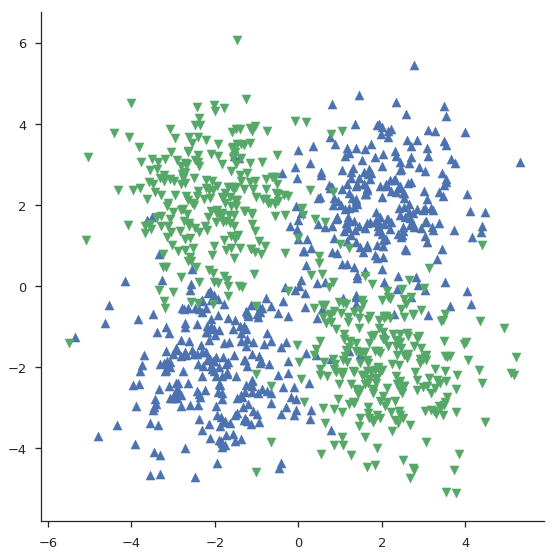

In [3]:
ax = plt.figure(figsize=(8, 8)).gca()
ax.scatter(data.x1[data.y==-1], data.x2[data.y==-1],
           c=DATA_COLORS[0], marker=DATA_MARKERS[0])
ax.scatter(data.x1[data.y==1], data.x2[data.y==1],
           c=DATA_COLORS[1], marker=DATA_MARKERS[1])
sns.despine()
plt.tight_layout()

In [4]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(39, 39)

# Sparse Model

0 - Kernels: 13/39 (0.3333333333333333). SV: 660/666 (0.990990990990991). Mean e: 0.0524. Median e: 0.0002. Std e: 0.0897. 
1 - Kernels: 19/39 (0.48717948717948717). SV: 662/666 (0.993993993993994). Mean e: 0.0684. Median e: 0.0004. Std e: 0.0853. 
2 - Kernels: 13/39 (0.3333333333333333). SV: 662/668 (0.9910179640718563). Mean e: 0.0568. Median e: 0.0001. Std e: 0.0885. 
3 - Kernels: 13/39 (0.3333333333333333). SV: 662/666 (0.993993993993994). Mean e: 0.0528. Median e: 0.0002. Std e: 0.0853. 
4 - Kernels: 13/39 (0.3333333333333333). SV: 659/666 (0.9894894894894894). Mean e: 0.0542. Median e: 0.0009. Std e: 0.0886. 
5 - Kernels: 13/39 (0.3333333333333333). SV: 661/668 (0.9895209580838323). Mean e: 0.0604. Median e: 0.0001. Std e: 0.0893. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 11.9612,  11.1893,  11.2876,  11.6792,  11.3957,  11.0439]),
 'score_time': array([ 1.4469,  1.3499,  1.3527,  1.3455,  1.3454,  1.3512]),
 'test_score': array([ 0.9461,  0.9012,  0.8976,  0.9222,  0.9162,  0.8946]),
 'train_score': array([ 0.9069,  0.9219,  0.9281,  0.9099,  0.9144,  0.9296])}

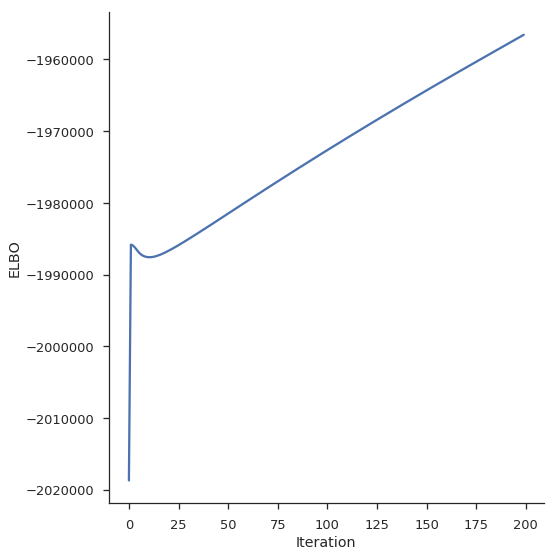

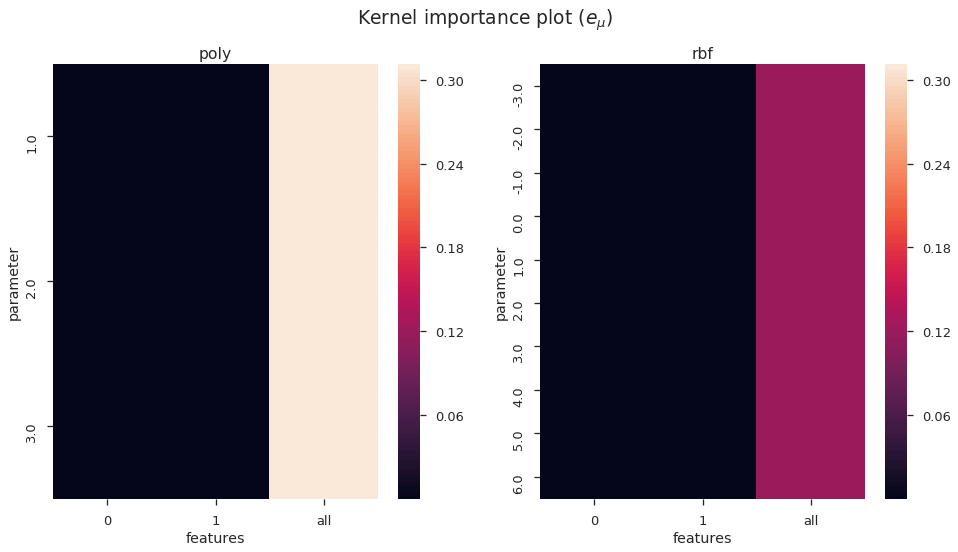

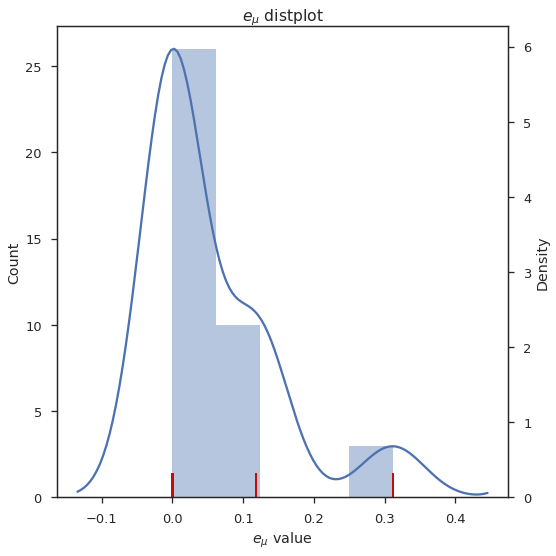

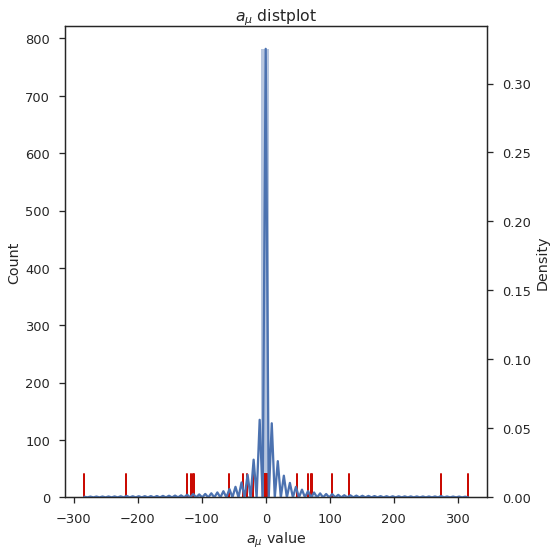

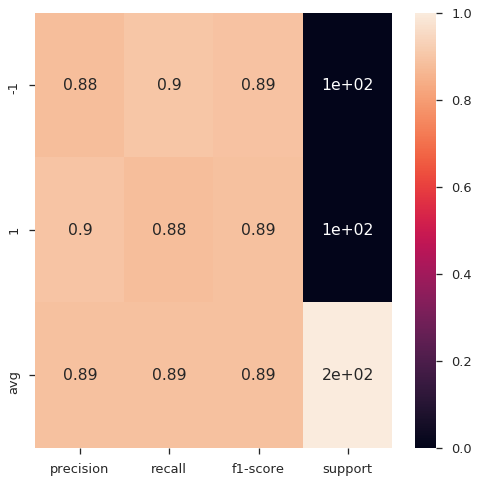

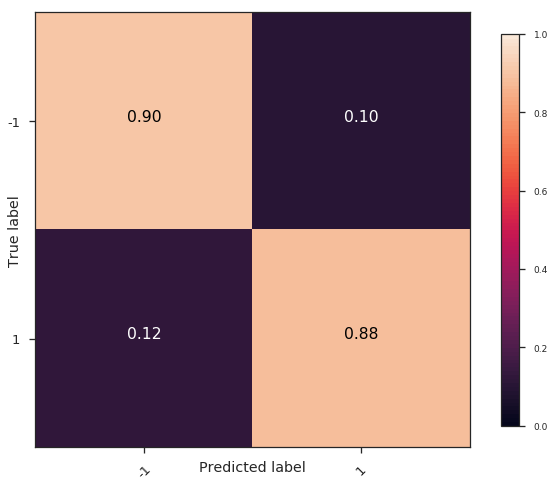

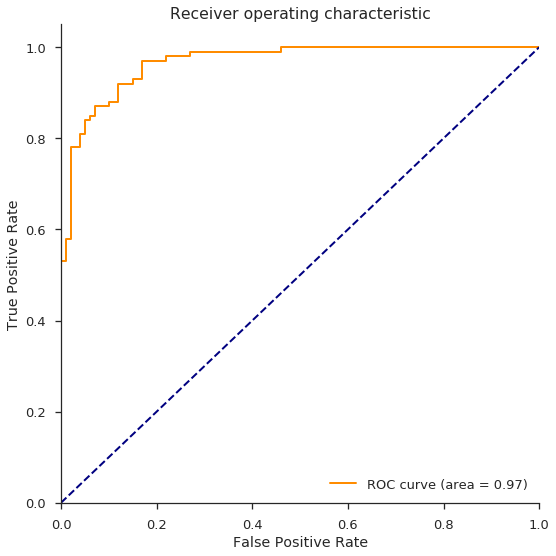

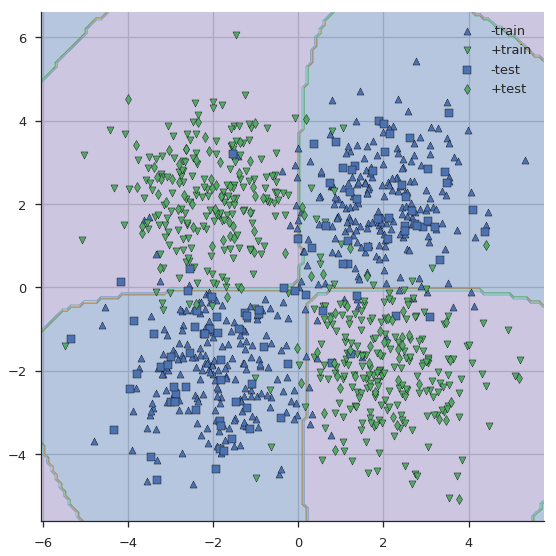

In [5]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1,
                     alpha_gamma=1, beta_gamma=1,
                     alpha_omega=1e-11, beta_omega=1e+9,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                     filter_kernels=False, filter_sv=False,
                     verbose=False)
evaluate_model(sparse_model, X, y, kernel_attrs)

# Dense Model

0 - Kernels: 39/39 (1.0). SV: 664/666 (0.996996996996997). Mean e: 0.0680. Median e: 0.0218. Std e: 0.0814. 
1 - Kernels: 39/39 (1.0). SV: 663/666 (0.9954954954954955). Mean e: 0.0862. Median e: 0.0316. Std e: 0.0728. 
2 - Kernels: 39/39 (1.0). SV: 663/668 (0.9925149700598802). Mean e: 0.0736. Median e: 0.0380. Std e: 0.0806. 
3 - Kernels: 39/39 (1.0). SV: 660/666 (0.990990990990991). Mean e: 0.1027. Median e: 0.0114. Std e: 0.1023. 
4 - Kernels: 39/39 (1.0). SV: 662/666 (0.993993993993994). Mean e: 0.0655. Median e: 0.0455. Std e: 0.0951. 
5 - Kernels: 39/39 (1.0). SV: 664/668 (0.9940119760479041). Mean e: 0.0491. Median e: 0.0125. Std e: 0.1004. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 12.0003,  11.5579,  11.6156,  11.7732,  11.5088,  11.6849]),
 'score_time': array([ 1.4403,  1.3429,  1.356 ,  1.3366,  1.3371,  1.3461]),
 'test_score': array([ 0.9102,  0.9162,  0.9066,  0.9162,  0.8982,  0.9217]),
 'train_score': array([ 0.9129,  0.9204,  0.9222,  0.9174,  0.9249,  0.9162])}

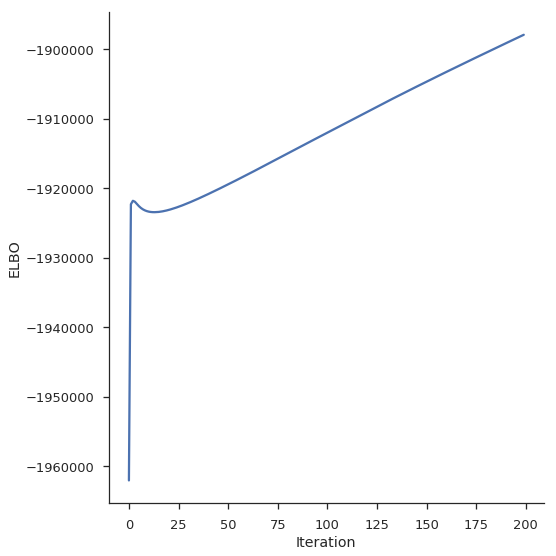

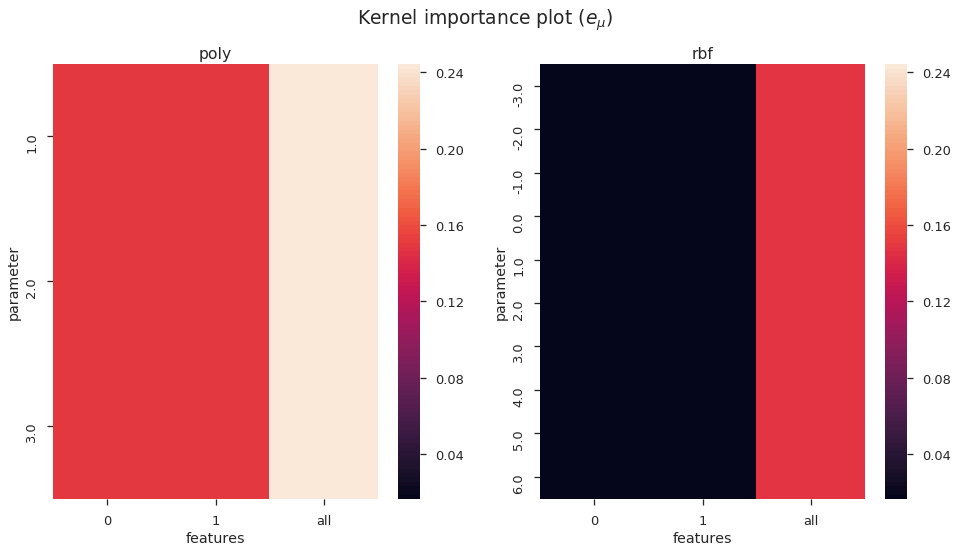

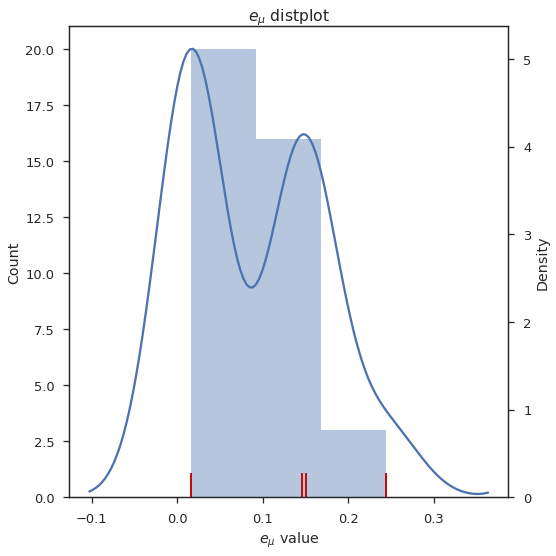

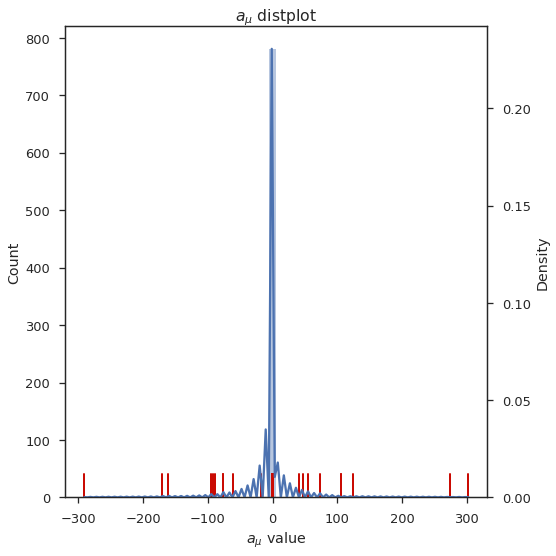

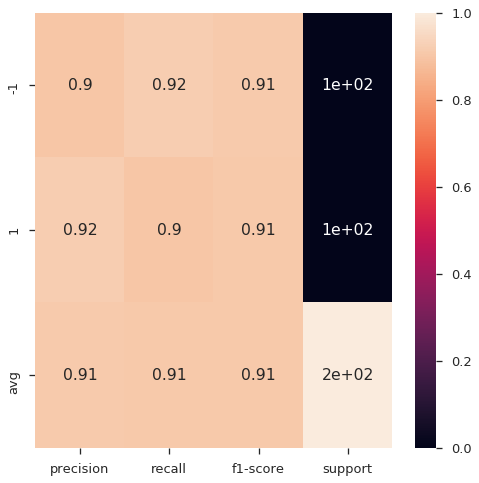

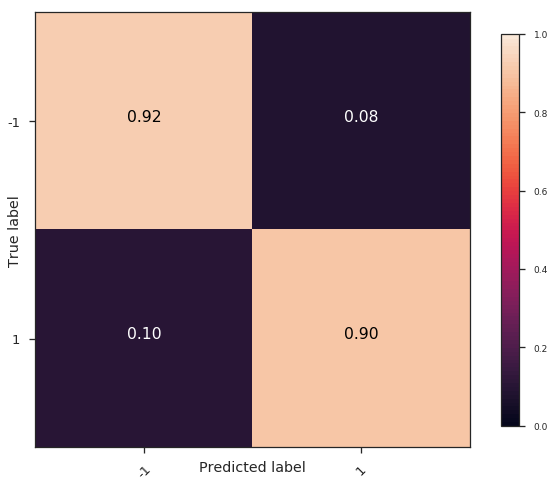

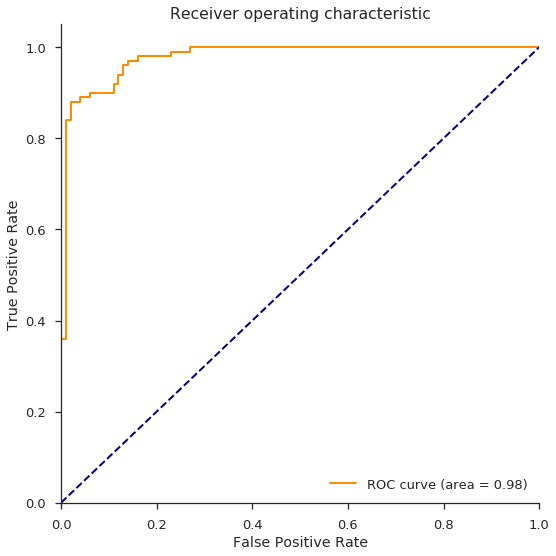

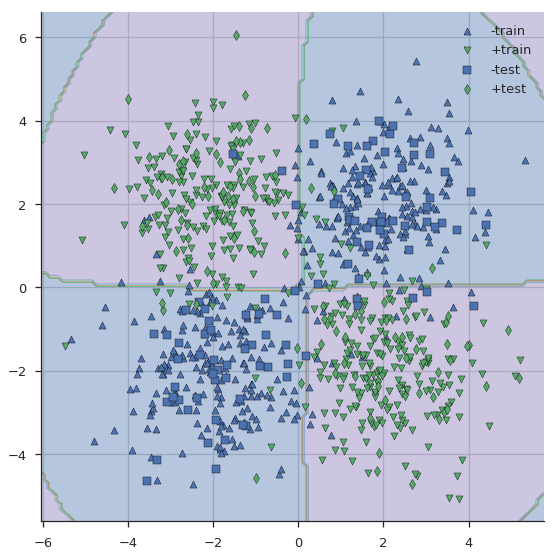

In [6]:
normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                     filter_kernels=False, filter_sv=False,
                     verbose=False)
evaluate_model(normal_model, X, y, kernel_attrs)

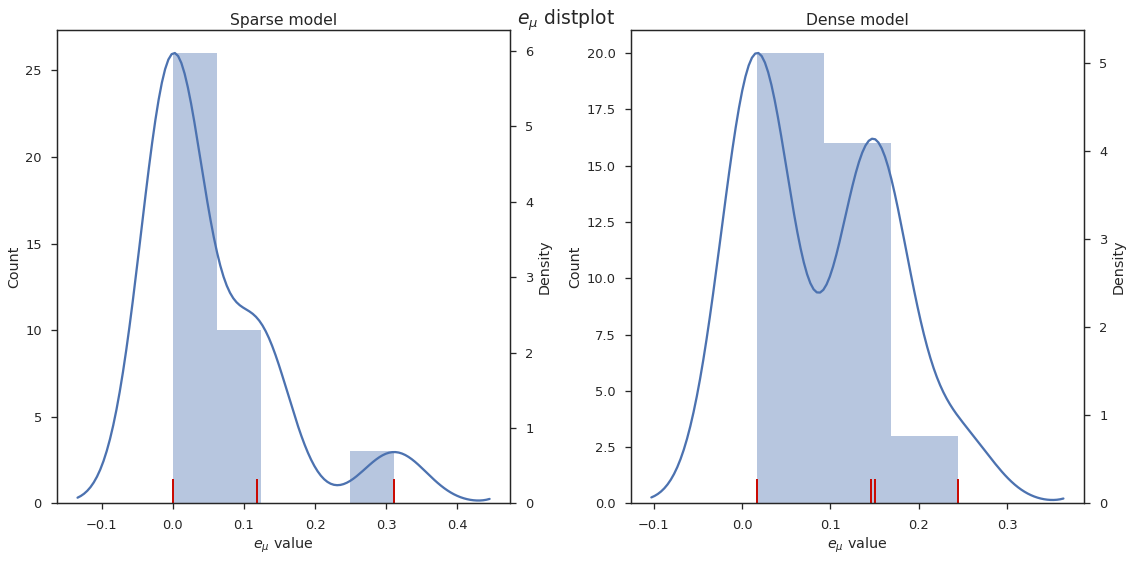

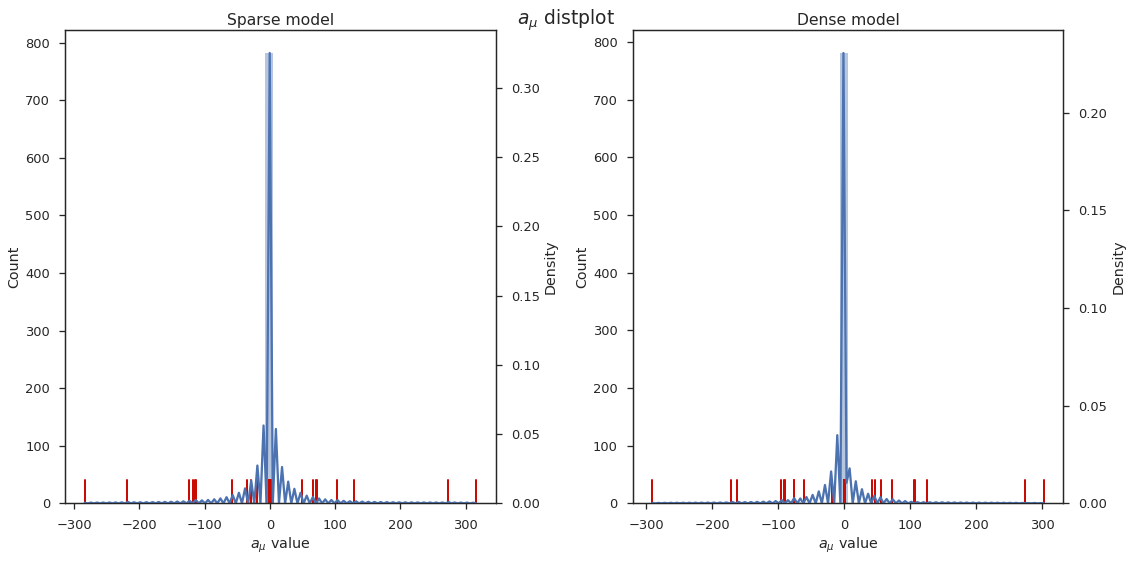

In [8]:
plot_e_a_mu(sparse_model, normal_model,
            'Sparse model', 'Dense model')